# Method 2 

## Pipeline 
![title](../assets/pipeleine.jpeg)

In [36]:
import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
import re
import gensim
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import  simple_preprocess
import spacy
from nltk import bigrams
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve,auc

In [37]:
df = pd.read_csv('../data/processed/author-parse-articles.csv')
df.head(1)

,Unnamed: 0,art_Unnamed: 0,art_uid,art_article_author,art_article_date,art_article_text,art_article_url,ref_Unnamed: 0,ref_Unnamed: 0.1,ref_uid,ref_title,ref_time,ref_source,ref_time-capture,ref_sc,ref_domain,ref_full-text,ref_sc2,ref_geo,ref_time_parsed
0,0,5,02b5cecd-fac3-4b89-80a2-5bc7d3356d51,['Jake Epstein'],2022-04-04 00:00:00,"Lithuania's top diplomat said buying Russian oil and gas is ""financing war crimes"" in Ukraine.\n...",https://www.businessinsider.com/lithuania-diplomat-says-buying-russian-oil-financing-war-crimes-...,16,16,02b5cecd-fac3-4b89-80a2-5bc7d3356d51,Lithuanian ambassador to Ukraine to return to Kyiv - Lithuanian foreign minister,4 hours ago,https://twitter.com/idreesali114/status/1510980406421639171,2022-04-04 13:47:10.051481,False,"data:image/svg+xml;base64,PHN2ZyB2ZXJzaW9uPSIxLjEiIHhtbG5zPSJodHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2Zy...",SourceOn live map\nTell friends\n4 hours ago - 54°41′N 25°16′E\nLithuanian ambassador to Ukraine...,False,54°41′N 25°16′E,2022-04-04 09:50:58


In [38]:
# Getting Domains From News Websites 
m = df['art_article_url'].str.extract('(?<=http://)(.*?)(?=/)|(?<=https://)(.*?)(?=/)')
m = m[0].fillna(m[1]).fillna(df['art_article_url'])
df['art_extracted_domain'] = m

### Split Based on Domains 

Topic Modelling 

1. We have on avg 7 articles from each domain(news site)
2. We only keep domains with more than 20 articles 
3. Topic model and find topics that a website is more likely to publish 




In [39]:
# mean of the number of article
df.groupby(['art_extracted_domain']).agg("count")["art_uid"].mean()

7.036585365853658

In [40]:
# select the # of articles which is greater than 20
df_domain = df.groupby(['art_extracted_domain']).agg("count")["art_uid"] 
domains = list(df_domain[df_domain>20].index)

In [41]:
df_filter = df[df["art_extracted_domain"].isin(domains)]

### Topic Discover

In [42]:

# load stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [43]:
# get article text
news = df_filter[["art_article_text"]]

In [44]:
# text preprocessing
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('[,\.!?]', '', sent)  # remove emails
        sent = sent.lower()  
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data = news['art_article_text'].values.tolist()
data = [i for i in data if type(i) != float ]
data_words = list(sent_to_words(data))

In [45]:
# remove stopwords
sentences=[]
for line in data_words:
    try:
        segs = [i for i in line if i not in stop_words]
        sentences.append(segs)
    except:
        print (line)
        continue

### Topic Discover

In [12]:
# Create Dictionary
id2word = Dictionary(sentences)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in sentences]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [13]:
for topic in lda_model.print_topics(num_topics=10, num_words=10):
    print (topic[1])

0.043*"said" + 0.034*"ukraine" + 0.025*"russian" + 0.024*"russia" + 0.013*"gmt" + 0.012*"war" + 0.011*"ukrainian" + 0.010*"says" + 0.007*"mar" + 0.007*"moscow"
0.046*"russian" + 0.028*"forces" + 0.026*"ukrainian" + 0.026*"city" + 0.018*"kyiv" + 0.016*"military" + 0.014*"troops" + 0.013*"mariupol" + 0.012*"said" + 0.008*"capital"
0.025*"ukraine" + 0.022*"us" + 0.015*"putin" + 0.015*"nato" + 0.014*"biden" + 0.012*"war" + 0.011*"russia" + 0.009*"military" + 0.009*"president" + 0.007*"wednesday"
0.038*"sanctions" + 0.021*"russia" + 0.021*"european" + 0.021*"russian" + 0.020*"eu" + 0.018*"said" + 0.014*"gas" + 0.014*"president" + 0.012*"putin" + 0.012*"oil"
0.018*"region" + 0.010*"armed" + 0.009*"plant" + 0.009*"russian" + 0.008*"according" + 0.008*"today" + 0.008*"head" + 0.008*"one" + 0.007*"occupiers" + 0.007*"information"
0.041*"bucha" + 0.027*"ukraine" + 0.022*"kyiv" + 0.020*"ukrainian" + 0.017*"images" + 0.016*"people" + 0.015*"bodies" + 0.013*"town" + 0.011*"russian" + 0.011*"march"


In [14]:
# 
# structure the main topic
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp[:10]])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.424994,"sanctions, russia, european, russian, eu, said...","[lithuanias, top, diplomat, said, buying, russ..."
1,1,3.0,0.649332,"sanctions, russia, european, russian, eu, said...","[live, blog, closed, follow, latest, updates, ..."
2,2,4.0,0.218611,"region, armed, plant, russian, according, toda...","[afu, repels, enemy, attacks, fronts, major, d..."
3,3,9.0,0.393797,"food, region, people, sullivan, pentagon, wedn...","[families, waiting, board, trains, eastern, uk..."
4,4,4.0,0.391495,"region, armed, plant, russian, according, toda...","[timeline, day, ukraines, defense, russian, ag..."
5,5,0.0,0.375786,"said, ukraine, russian, russia, gmt, war, ukra...","[united, states, britain, announced, plans, mo..."
6,6,9.0,0.393797,"food, region, people, sullivan, pentagon, wedn...","[families, waiting, board, trains, eastern, uk..."
7,7,0.0,0.546153,"said, ukraine, russian, russia, gmt, war, ukra...","[soldiers, walk, amid, destroyed, russian, tan..."
8,8,1.0,0.380446,"russian, forces, ukrainian, city, kyiv, milita...","[serhiy, haidai, head, luhansk, regional, mili..."
9,9,8.0,0.998396,"april, said, russian, ukrainian, ukraine, russ...","[russias, defense, ministry, warned, april, in..."


In [15]:
"""get samples of sentences that most represent a given topic."""
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.906969,"said, ukraine, russian, russia, gmt, war, ukrainian, says, mar, moscow","[lviv, next, round, face, face, talks, ukraine, russia, place, turkey, march, ukrainian, negotia..."
1,1.0,0.751001,"russian, forces, ukrainian, city, kyiv, military, troops, mariupol, said, capital","[opposite, turned, true, russian, forces, retreated, around, kyiv, ukrainian, forces, gained, gr..."
2,2.0,0.809913,"ukraine, us, putin, nato, biden, war, russia, military, president, wednesday","[us, president, joe, biden, chinese, president, xi, jinping, virtual, meeting, friday, photo, wh..."
3,3.0,0.899253,"sanctions, russia, european, russian, eu, said, gas, president, putin, oil","[coronavirus, bulletin, stay, informed, daily, latest, news, advice, covid, editors, us, news, w..."
4,4.0,0.620007,"region, armed, plant, russian, according, today, head, one, occupiers, information","[term, search, search, google]"
5,5.0,0.825081,"bucha, ukraine, kyiv, ukrainian, images, people, bodies, town, russian, march","[photos, russia, keep, attacks, parts, ukraine, millions, displaced, editors, note, graphic, con..."
6,6.0,0.698406,"russia, ukraine, security, pm, un, council, february, united, reuters, international","[united, nations, security, council, meets, un, headquarters, new, york, city, february, united,..."
7,7.0,0.363055,"mr, officials, new, russia, york, image, credit, times, like, michael","[zaporizhzhia, nuclear, power, plant, biggest, europe, photo, epa, efe]"
8,8.0,0.998396,"april, said, russian, ukrainian, ukraine, russia, kyiv, russias, attacks, city","[russias, defense, ministry, warned, april, intensify, attacks, ukrainian, capital, kyiv, accusi..."
9,9.0,0.393797,"food, region, people, sullivan, pentagon, wednesday, week, since, million, war","[families, waiting, board, trains, eastern, ukrainian, city, kramatorsk, tuesday, spurred, repor..."


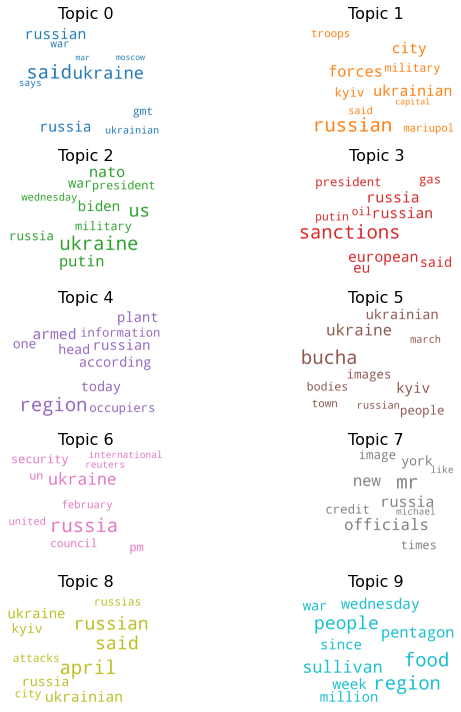

In [16]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [47]:

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


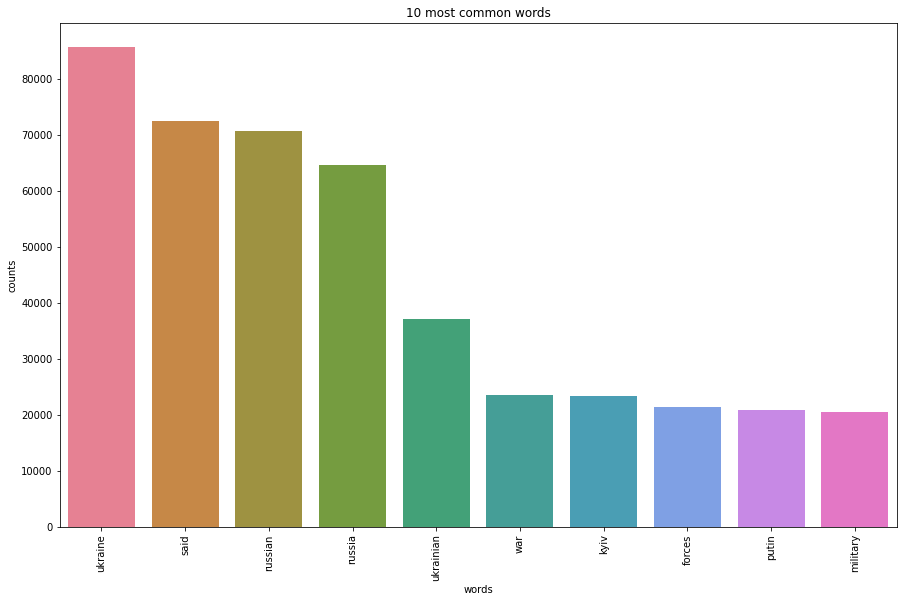

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(news[news["art_article_text"].notnull()]['art_article_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### Bigrams

In [49]:
# 剔除bigrams中没有主题词的词组
def word_drop_keywords(x):
    arr = [i.strip() for i in  x[0].split(",") if i.strip() ]
    if len(arr) >=5:
        key_words = arr[:5]
    else:
        key_words = arr
    words = x[1]
    keep_words = []
    for i in range(len(words)):
        
        if i == 0:
            if len(set(words[i:i+1])&set(key_words)) > 0 :
                
                keep_words.append(words[i])
        elif i < len(words)-1 and i > 0:
            if len(set(words[i:i+2])&set(key_words)) > 0 or len(set(words[i-1:i+1])&set(key_words)) > 0 :

                keep_words.append(words[i])
        else:
            if words[i-1] in key_words:
                keep_words.append(words[i])
    return keep_words

In [50]:
new_text = df_dominant_topic[["Keywords","Text"]].apply(lambda x:word_drop_keywords(x),axis=1)
new_text = [i for i in new_text if len(i) >0]


In [53]:
new_data = [" ".join(i) for i in new_text ]

In [54]:
# Build the bigram models
bigram = gensim.models.Phrases(new_data, min_count=2, threshold=1) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [55]:
# keep N, adj, verb,adv,
# text preprocessing
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        # print(sent)
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(new_data) 


In [56]:
# Create Dictionary
id2word = Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [57]:
for topic in lda_model.print_topics(num_topics=5, num_words=10):
    print (topic[1])

0.174*"ukrainian" + 0.109*"city" + 0.091*"kyiv" + 0.047*"force" + 0.019*"port" + 0.015*"invade" + 0.010*"tank" + 0.010*"hit" + 0.010*"mariupol" + 0.008*"advance"
0.130*"region" + 0.116*"official" + 0.106*"people" + 0.039*"image" + 0.036*"senior" + 0.029*"luhansk" + 0.028*"leave" + 0.023*"announce" + 0.022*"tell" + 0.022*"donetsk"
0.360*"ukraine" + 0.061*"invasion" + 0.047*"sanction" + 0.018*"support" + 0.017*"invade" + 0.009*"weapon" + 0.009*"people" + 0.008*"include" + 0.008*"help" + 0.008*"share"
0.138*"apr" + 0.094*"war" + 0.090*"gmt" + 0.023*"kill" + 0.022*"accuse" + 0.018*"statement" + 0.011*"new" + 0.010*"provide" + 0.008*"authority" + 0.008*"civilian"
0.365*"russian" + 0.042*"force" + 0.034*"troop" + 0.020*"attack" + 0.016*"military" + 0.015*"soldier" + 0.012*"official" + 0.010*"diplomat" + 0.008*"capital" + 0.007*"border"


In [58]:
# 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp][:10])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,5), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [59]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.87762,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[russian, oil, half, russian, gas, buy, russian, oil, bucha, russian, buy, russian, oil, half, r..."
1,1,4.0,0.83501,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[armed, force, perm, armed, force, punish, attack, russian, invader, associate, hospital, kyiv, ..."
2,2,1.0,0.96647,"region, official, people, image, senior, luhansk, leave, announce, tell, donetsk","[luhansk, region, ruin, people, leave, region, region, tell, donetsk, region, photo, crowd, peop..."
3,3,4.0,0.93367,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[russian, aggression, russian, missile, russian, occupier, already, russian, occupier, list, rus..."
4,4,4.0,0.55260,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[bucha, ukraine, image, ukraine, require, unbelievable, russian, ambassador, happen, russian, ru..."
5,5,1.0,0.96647,"region, official, people, image, senior, luhansk, leave, announce, tell, donetsk","[luhansk, region, ruin, people, leave, region, region, tell, donetsk, region, photo, crowd, peop..."
6,6,2.0,0.49990,"ukraine, invasion, sanction, support, invade, weapon, people, include, help, share","[tank, russian, military, case, russian, opposition, accusation, forward, round, ukraine, talk, ..."
7,7,4.0,0.64996,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[russian, military, leader, kyiv, northern, ukrainian, chernihiv]"
8,8,4.0,0.91585,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[attack, ukrainian, capital, target, russian, border, flagship, ukrainian, proud, day, russian, ..."
9,9,4.0,0.91585,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[attack, ukrainian, capital, target, russian, border, flagship, ukrainian, proud, day, russian, ..."


In [60]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.89968,"ukrainian, city, kyiv, force, port, invade, tank, hit, mariupol, advance","[city, constant, air, force, large, city, kharkiv]"
1,1.0,0.98403,"region, official, people, image, senior, luhansk, leave, announce, tell, donetsk","[getty, image, anastasia, getty, image, russian, getty, image, toggle, getty, image, toggle, get..."
2,2.0,0.95386,"ukraine, invasion, sanction, support, invade, weapon, people, include, help, share","[citizen, ukraine, ready, support, ukraine, square, citizen, ukraine, ready, evil, ukraine, defe..."
3,3.0,0.79998,"apr, war, gmt, kill, accuse, statement, new, provide, authority, civilian","[rage, war, hope]"
4,4.0,0.96624,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[leader, import, russian, oil, dependence, extensively, away, russian, energy, dependency, russi..."


In [61]:
for topic in lda_model.print_topics(num_topics=10, num_words=10):
    print (topic[1])

0.174*"ukrainian" + 0.109*"city" + 0.091*"kyiv" + 0.047*"force" + 0.019*"port" + 0.015*"invade" + 0.010*"tank" + 0.010*"hit" + 0.010*"mariupol" + 0.008*"advance"
0.130*"region" + 0.116*"official" + 0.106*"people" + 0.039*"image" + 0.036*"senior" + 0.029*"luhansk" + 0.028*"leave" + 0.023*"announce" + 0.022*"tell" + 0.022*"donetsk"
0.360*"ukraine" + 0.061*"invasion" + 0.047*"sanction" + 0.018*"support" + 0.017*"invade" + 0.009*"weapon" + 0.009*"people" + 0.008*"include" + 0.008*"help" + 0.008*"share"
0.138*"apr" + 0.094*"war" + 0.090*"gmt" + 0.023*"kill" + 0.022*"accuse" + 0.018*"statement" + 0.011*"new" + 0.010*"provide" + 0.008*"authority" + 0.008*"civilian"
0.365*"russian" + 0.042*"force" + 0.034*"troop" + 0.020*"attack" + 0.016*"military" + 0.015*"soldier" + 0.012*"official" + 0.010*"diplomat" + 0.008*"capital" + 0.007*"border"


### Visualization

In [62]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.89968,"ukrainian, city, kyiv, force, port, invade, tank, hit, mariupol, advance","[city, constant, air, force, large, city, kharkiv]"
1,1.0,0.98403,"region, official, people, image, senior, luhansk, leave, announce, tell, donetsk","[getty, image, anastasia, getty, image, russian, getty, image, toggle, getty, image, toggle, get..."
2,2.0,0.95386,"ukraine, invasion, sanction, support, invade, weapon, people, include, help, share","[citizen, ukraine, ready, support, ukraine, square, citizen, ukraine, ready, evil, ukraine, defe..."
3,3.0,0.79998,"apr, war, gmt, kill, accuse, statement, new, provide, authority, civilian","[rage, war, hope]"
4,4.0,0.96624,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[leader, import, russian, oil, dependence, extensively, away, russian, energy, dependency, russi..."


In [63]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.87762,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[russian, oil, half, russian, gas, buy, russian, oil, bucha, russian, buy, russian, oil, half, r..."
1,1,4.0,0.83501,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[armed, force, perm, armed, force, punish, attack, russian, invader, associate, hospital, kyiv, ..."
2,2,1.0,0.96647,"region, official, people, image, senior, luhansk, leave, announce, tell, donetsk","[luhansk, region, ruin, people, leave, region, region, tell, donetsk, region, photo, crowd, peop..."
3,3,4.0,0.93367,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[russian, aggression, russian, missile, russian, occupier, already, russian, occupier, list, rus..."
4,4,4.0,0.55260,"russian, force, troop, attack, military, soldier, official, diplomat, capital, border","[bucha, ukraine, image, ukraine, require, unbelievable, russian, ambassador, happen, russian, ru..."


Document_No                                                                                                             0
Dominant_Topic                                                                                                        4.0
Topic_Perc_Contrib                                                                                                0.84945
Keywords                           russian, ukraine, force, invasion, sanction, troop, statement, war, support, zelenskyy
Text                  [buy, russian, oil, urge, country, half, russian, gas, export, european, country, urge, european...
Name: 0, dtype: object

Common Topic words：  ['russian']
Topic Word Analysis：  russian


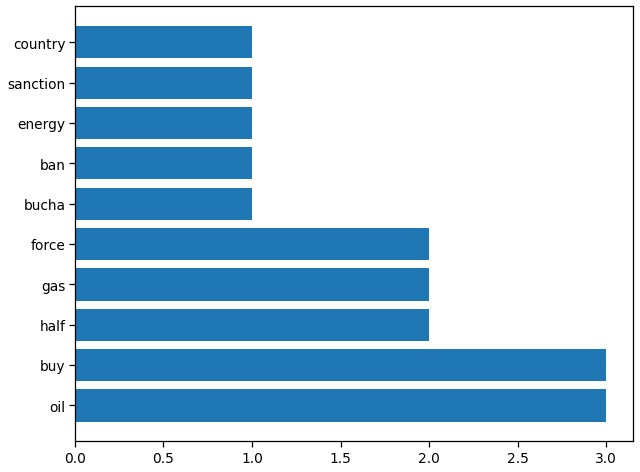

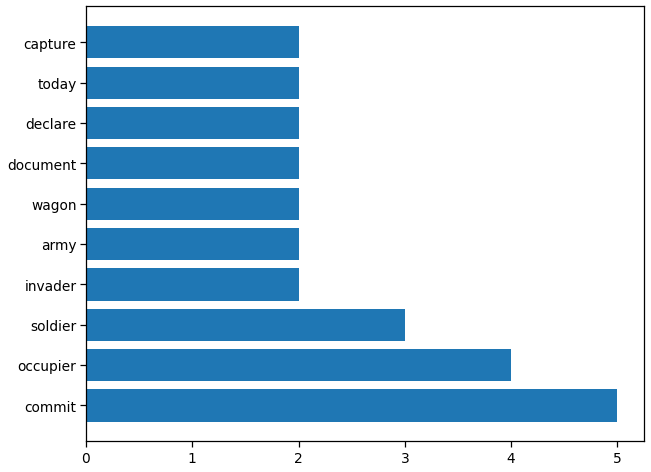

In [65]:
# 得到所有主题关键词，用作计算每篇文章的top 5 关键词
def slt_all_key_words(df_dominant_topic):
    all_kw = [ i.replace(" ","").split(",") for i in df_dominant_topic["Keywords"].values]
    all_kw_unique = set()
    for kw in all_kw:
        all_kw_unique = set(kw) | all_kw_unique
    return list(all_kw_unique)

# 得到文章的top5关键词
def doc_top5_words(txt,all_kv):
    kv_dic = {} 
    for k in txt:
        if k in all_kv:
            kv_dic[k] = kv_dic.get(k,0) + 1
    kv_dic = sorted(kv_dic,key=lambda x: x[1],reverse=True)
    top5_key = []
    for i,v in enumerate(kv_dic):
        if i <= 4:
            top5_key.append(v)
    return top5_key

# 统计共有关键词的词组中另一个词出现的频率
def not_keywords_frequncy(text,common_keywords):
    word_dic = {}
    for grams in bigrams(text):
        if len(set([common_keywords]) & set(grams)) >0:
            tmp = list(set(grams).difference(set([common_keywords])))
            for k in tmp:
                word_dic[k] = word_dic.get(k,0) + 1
    return word_dic


# 对上述结果频率进行可视化
def draw_from_dict(dicdata,RANGE=10, heng=1):
    plt.figure(figsize=(10,8))
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    # print(by_value)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    else:
        return None

# 得到所有关键词
all_key_words = slt_all_key_words(df_dominant_topic)

# 任取两篇文章进行分析(自己选择文章)
news_tmp_1 = df_dominant_topic.iloc[0]
news_tmp_2 = df_dominant_topic.iloc[1]

# 文章文本
news_text_1 = news_tmp_1["Text"]
news_text_2 = news_tmp_2["Text"]

# 得到文章关键词
keys_word_1 = doc_top5_words(news_text_1,all_key_words)
keys_word_2 =  doc_top5_words(news_text_2,all_key_words)

# 共有关键词
common_keywords = list(set(keys_word_1) & set(keys_word_2))
print("Common Topic words： ",common_keywords )



# 依次分析每个keyword 的另外的词组的评率
for keyword in common_keywords:
    print("Topic Word Analysis： ",keyword)
    word_dic_1 = not_keywords_frequncy(news_text_1,keyword)
    draw_from_dict(word_dic_1)

    word_dic_2 = not_keywords_frequncy(news_text_2,keyword)
    draw_from_dict(word_dic_2)

    print("\n")

In [91]:
# 得到所有主题关键词，用作计算每篇文章的top 5 关键词
def slt_all_key_words(df_dominant_topic):
    all_kw = [ i.replace(" ","").split(",") for i in df_dominant_topic["Keywords"].values]
    all_kw_unique = set()
    for kw in all_kw:
        all_kw_unique = set(kw) | all_kw_unique
    return list(all_kw_unique)

# 得到文章的top5关键词
def doc_top5_words(txt,all_kv):
    kv_dic = {} 
    for k in txt:
        if k in all_kv:
            kv_dic[k] = kv_dic.get(k,0) + 1
    kv_dic = sorted(kv_dic,key=lambda x: x[1],reverse=True)
    top5_key = []
    for i,v in enumerate(kv_dic):
        if i <= 4:
            top5_key.append(v)
    return top5_key

# 统计共有关键词的词组中另一个词出现的频率
def not_keywords_frequncy(text,common_keywords):
    word_dic = {}
    for grams in bigrams(text):
        if len(set([common_keywords]) & set(grams)) >0:
            tmp = list(set(grams).difference(set([common_keywords])))
            for k in tmp:
                word_dic[k] = word_dic.get(k,0) + 1
    return word_dic


# 对上述结果频率进行可视化
def draw_from_dict(dicdata,RANGE=10, heng=1):
    plt.figure(figsize=(10,8))
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    # print(by_value)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    else:
        return None

# 得到所有关键词
all_key_words = slt_all_key_words(df_dominant_topic)

# 任取两篇文章进行分析(自己选择文章)
news_tmp_1 = df_dominant_topic.iloc[0]
news_tmp_2 = df_dominant_topic.iloc[2]

# 文章文本
news_text_1 = news_tmp_1["Text"]
news_text_2 = news_tmp_2["Text"]

# 得到文章关键词
keys_word_1 = doc_top5_words(news_text_1,all_key_words)
keys_word_2 =  doc_top5_words(news_text_2,all_key_words)

# 共有关键词
common_keywords = list(set(keys_word_1) & set(keys_word_2))
print("Common Topic words： ",common_keywords )



# 依次分析每个keyword 的另外的词组的评率
for keyword in common_keywords:
    print("Topic Word Analysis： ",keyword)
    word_dic_1 = not_keywords_frequncy(news_text_1,keyword)
    draw_from_dict(word_dic_1)

    word_dic_2 = not_keywords_frequncy(news_text_2,keyword)
    draw_from_dict(word_dic_2)

    print("\n")

Common Topic words：  []


Common Topic words：  ['russian', 'force']
Topic Word Analysis：  russian


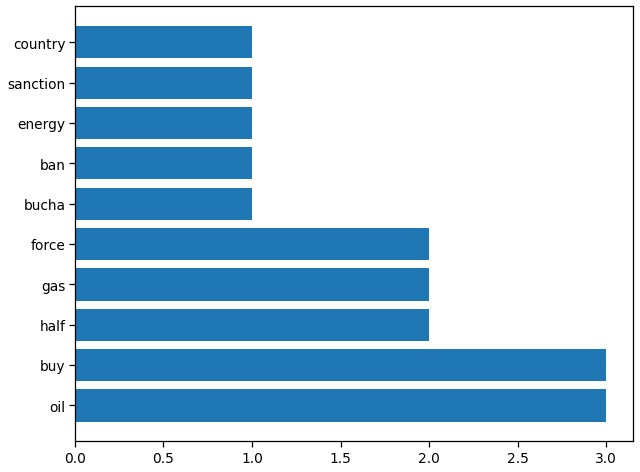

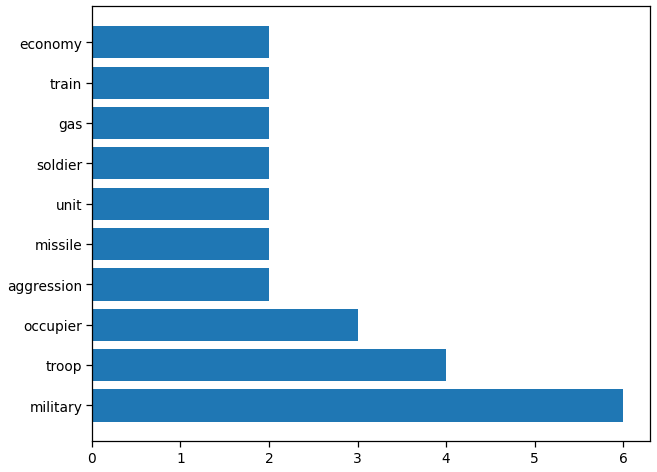



Topic Word Analysis：  force


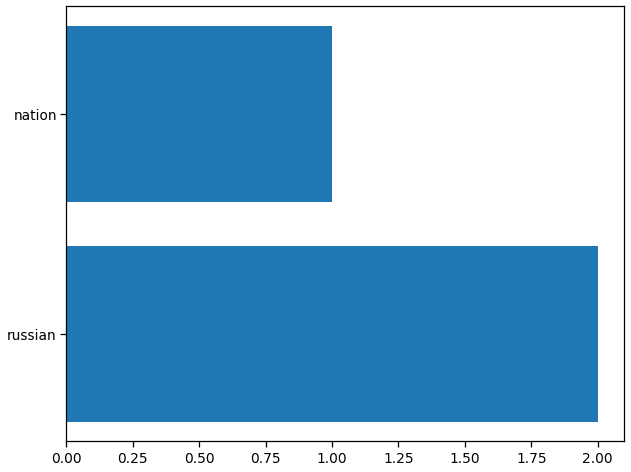

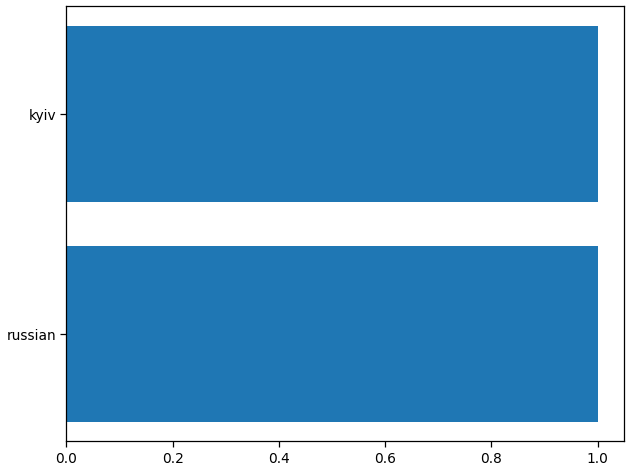

In [92]:
# 得到所有主题关键词，用作计算每篇文章的top 5 关键词
def slt_all_key_words(df_dominant_topic):
    all_kw = [ i.replace(" ","").split(",") for i in df_dominant_topic["Keywords"].values]
    all_kw_unique = set()
    for kw in all_kw:
        all_kw_unique = set(kw) | all_kw_unique
    return list(all_kw_unique)

# 得到文章的top5关键词
def doc_top5_words(txt,all_kv):
    kv_dic = {} 
    for k in txt:
        if k in all_kv:
            kv_dic[k] = kv_dic.get(k,0) + 1
    kv_dic = sorted(kv_dic,key=lambda x: x[1],reverse=True)
    top5_key = []
    for i,v in enumerate(kv_dic):
        if i <= 4:
            top5_key.append(v)
    return top5_key

# 统计共有关键词的词组中另一个词出现的频率
def not_keywords_frequncy(text,common_keywords):
    word_dic = {}
    for grams in bigrams(text):
        if len(set([common_keywords]) & set(grams)) >0:
            tmp = list(set(grams).difference(set([common_keywords])))
            for k in tmp:
                word_dic[k] = word_dic.get(k,0) + 1
    return word_dic


# 对上述结果频率进行可视化
def draw_from_dict(dicdata,RANGE=10, heng=1):
    plt.figure(figsize=(10,8))
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    # print(by_value)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    else:
        return None

# 得到所有关键词
all_key_words = slt_all_key_words(df_dominant_topic)

# 任取两篇文章进行分析(自己选择文章)
news_tmp_1 = df_dominant_topic.iloc[0]
news_tmp_2 = df_dominant_topic.iloc[3]

# 文章文本
news_text_1 = news_tmp_1["Text"]
news_text_2 = news_tmp_2["Text"]

# 得到文章关键词
keys_word_1 = doc_top5_words(news_text_1,all_key_words)
keys_word_2 =  doc_top5_words(news_text_2,all_key_words)

# 共有关键词
common_keywords = list(set(keys_word_1) & set(keys_word_2))
print("Common Topic words： ",common_keywords )



# 依次分析每个keyword 的另外的词组的评率
for keyword in common_keywords:
    print("Topic Word Analysis： ",keyword)
    word_dic_1 = not_keywords_frequncy(news_text_1,keyword)
    draw_from_dict(word_dic_1)

    word_dic_2 = not_keywords_frequncy(news_text_2,keyword)
    draw_from_dict(word_dic_2)

    print("\n")

Common Topic words：  ['russian']
Topic Word Analysis：  russian


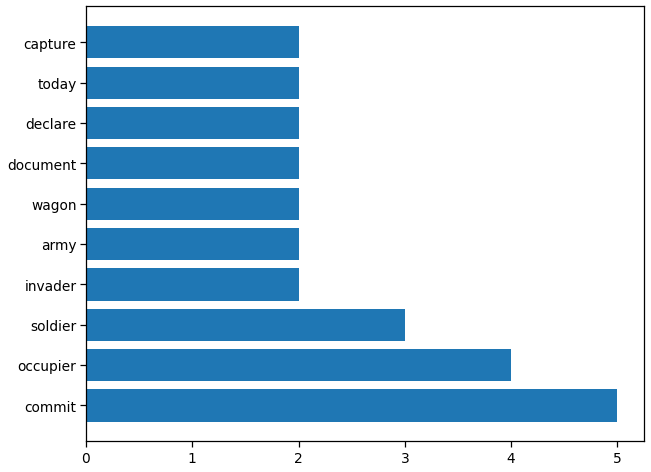

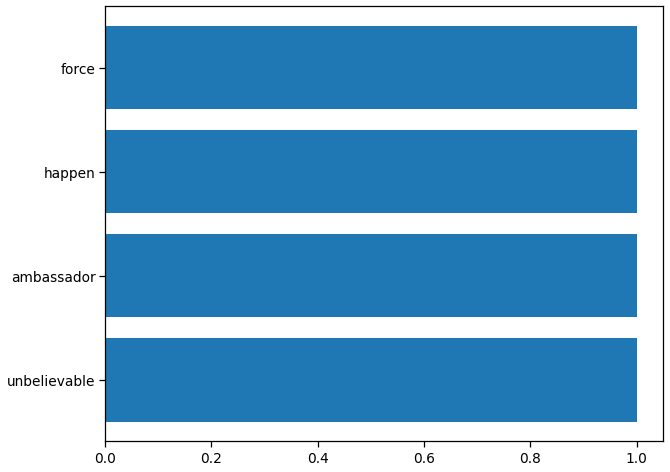

In [93]:
# 得到所有主题关键词，用作计算每篇文章的top 5 关键词
def slt_all_key_words(df_dominant_topic):
    all_kw = [ i.replace(" ","").split(",") for i in df_dominant_topic["Keywords"].values]
    all_kw_unique = set()
    for kw in all_kw:
        all_kw_unique = set(kw) | all_kw_unique
    return list(all_kw_unique)

# 得到文章的top5关键词
def doc_top5_words(txt,all_kv):
    kv_dic = {} 
    for k in txt:
        if k in all_kv:
            kv_dic[k] = kv_dic.get(k,0) + 1
    kv_dic = sorted(kv_dic,key=lambda x: x[1],reverse=True)
    top5_key = []
    for i,v in enumerate(kv_dic):
        if i <= 4:
            top5_key.append(v)
    return top5_key

# 统计共有关键词的词组中另一个词出现的频率
def not_keywords_frequncy(text,common_keywords):
    word_dic = {}
    for grams in bigrams(text):
        if len(set([common_keywords]) & set(grams)) >0:
            tmp = list(set(grams).difference(set([common_keywords])))
            for k in tmp:
                word_dic[k] = word_dic.get(k,0) + 1
    return word_dic


# 对上述结果频率进行可视化
def draw_from_dict(dicdata,RANGE=10, heng=1):
    plt.figure(figsize=(10,8))
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    # print(by_value)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    else:
        return None

# 得到所有关键词
all_key_words = slt_all_key_words(df_dominant_topic)

# 任取两篇文章进行分析(自己选择文章)
news_tmp_1 = df_dominant_topic.iloc[1]
news_tmp_2 = df_dominant_topic.iloc[4]

# 文章文本
news_text_1 = news_tmp_1["Text"]
news_text_2 = news_tmp_2["Text"]

# 得到文章关键词
keys_word_1 = doc_top5_words(news_text_1,all_key_words)
keys_word_2 =  doc_top5_words(news_text_2,all_key_words)

# 共有关键词
common_keywords = list(set(keys_word_1) & set(keys_word_2))
print("Common Topic words： ",common_keywords )



# 依次分析每个keyword 的另外的词组的评率
for keyword in common_keywords:
    print("Topic Word Analysis： ",keyword)
    word_dic_1 = not_keywords_frequncy(news_text_1,keyword)
    draw_from_dict(word_dic_1)

    word_dic_2 = not_keywords_frequncy(news_text_2,keyword)
    draw_from_dict(word_dic_2)

    print("\n")

###  Theme Pridict

In [33]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.84945,"russian, ukraine, force, invasion, sanction, troop, statement, war, support, zelenskyy","[buy, russian, oil, urge, country, half, russian, gas, export, european, country, urge, european..."
1,1,3.0,0.47905,"russian, ukrainian, force, city, kyiv, troop, attack, military, soldier, capital","[staff, armed, force, perm, region, republic, armed, force, punish, russian, federation, attack,..."
2,2,0.0,0.98739,"region, people, official, image, accord, announce, tell, senior, luhansk, food","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
3,3,4.0,0.47451,"russian, ukraine, force, invasion, sanction, troop, statement, war, support, zelenskyy","[defense, russian, aggression, russian, missile, russian, occupier, already, russian, occupier, ..."
4,4,4.0,0.80834,"russian, ukraine, force, invasion, sanction, troop, statement, war, support, zelenskyy","[allegation, russian, troop, bucha, ukraine, image, ukraine, require, greenfield, vote, bucha, c..."


In [67]:
"""word2vec：将词转化成向量"""
def word2vec_feature(data,emb_size = 32 ):

    sentences = data['Text'].values.tolist()

    model = Word2Vec(sentences, vector_size=emb_size, window=6, min_count=5, sg=0, hs=0, seed=1, epochs=5)

    emb_matrix = []

    for seq in sentences:
        vec = []
        for w in seq:
            if w in model.wv:
                vec.append(model.wv[w])
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    
    vec_feature = pd.DataFrame(emb_matrix,columns=['tag_emb_{}'.format(i) for i in range(emb_size)])
    return vec_feature

In [68]:
"""Word2Vec 编码"""
embed_size = 32
vec_feature = word2vec_feature(df_dominant_topic,emb_size = embed_size)

In [69]:
theme_label = df_dominant_topic["Dominant_Topic"]

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
# divide data
x_train,x_test,y_train,y_test = train_test_split(vec_feature,theme_label)

In [72]:
"""random forest"""
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle

dtc = RandomForestClassifier(random_state=0)
# 
clf = dtc.fit(X=x_train, y=y_train)

# The probability score, y_score, 
# is a matrix with a shape of (number of test set entries, number of classification species).

y_score = clf.predict_proba(x_test)  

In [73]:
y_score

array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.74, 0.  , 0.26],
       ...,
       [0.04, 0.02, 0.87, 0.01, 0.06],
       [0.  , 0.  , 0.86, 0.  , 0.14],
       [0.28, 0.  , 0.  , 0.  , 0.72]])

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

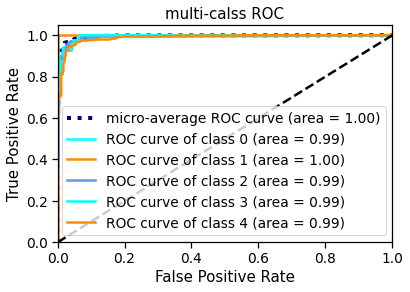

In [88]:
# 进行roc曲线可视化，auc值在0-1，值越大，预测准确率越高

y_label = pd.get_dummies(y_test).values
y_score = clf.predict_proba(x_test)
n_classes = 5


# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 

fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
 
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")

plt.show()

In [89]:
"""LR 逻辑回归多分类"""
from sklearn.linear_model import LogisticRegression

# 训练
clf = LogisticRegression(multi_class="multinomial", solver="newton-cg", max_iter=1000)
clf.fit(x_train,y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='newton-cg')

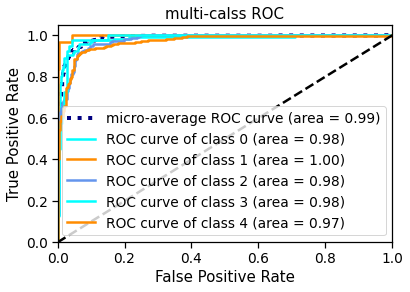

In [90]:
# 进行roc曲线可视化，auc值在0-1，值越大，预测准确率越高
y_label = pd.get_dummies(y_test).values
y_score = clf.predict_proba(x_test)
n_classes = 5


# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 

fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
 
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()

# Results and Insights

## Sample 1 

![title](../assets/m2o2.png)

## Sample 2 

![title](../assets/m2o1.png)